## Objective:
- Wants to increase volume of sales, particularly sales from new users
- Investigate the funnel and make suggestions to improve conversion rates
    - Provide full funnel process (include conversion rates) for both desktop and mobile
    - Insights for production team to focus on in order to improve conversion rates

In [1]:
# Import numpy and pandas
import numpy as np
import pandas as pd

# Import matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sns

# Import stats from scipy
from scipy import stats

In [2]:
# Import the 5 raw datasets

# Import the user_table
user_table = pd.read_csv('user_table.csv')

# Import the home_page_table
home_page = pd.read_csv('home_page_table.csv')

# Import the search_page_table
search_page = pd.read_csv('search_page_table.csv')

# Import the payment_page_table
payment_page = pd.read_csv('payment_page_table.csv')

# Import the payment_confirmation_table
payment_confirmation = pd.read_csv('payment_confirmation_table.csv')

Notes:
- Order of funnel:
    - user page -> home page -> search page -> payment page -> payment confirmation
- Only the user_table contains user information. The remainder of the pages simply tell if the user arrived at the pages.
- All data tables only include information regarding the user's FIRST visit

Let's check the user data table first to make sure all information is as we expect. From there, I will use a (left) merge from user data to all other tables. In between, I can count where the percentage of users that made it through to the current page.

In [3]:
# Show the user_table information
user_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90400 entries, 0 to 90399
Data columns (total 4 columns):
user_id    90400 non-null int64
date       90400 non-null object
device     90400 non-null object
sex        90400 non-null object
dtypes: int64(1), object(3)
memory usage: 2.8+ MB


In [4]:
# Make sure user id is a unique identifier
assert len(user_table) == user_table['user_id'].nunique()

# If so, set the user_id as the index to the table
user_table.set_index('user_id', inplace=True)

In [5]:
# Device should only be mobile or desktop
user_table['device'].unique()

array(['Desktop', 'Mobile'], dtype=object)

In [6]:
# Device should only be male or female
user_table['sex'].unique()

array(['Female', 'Male'], dtype=object)

It looks like all values are as we expect. Before I move forward, I will convert the date column to datetime objects and engineer some features from it (particularly month, weekofyear, and weekday).

In [7]:
# Convert the date column to datetime objects
user_table['date'] = pd.to_datetime(user_table['date'])

In [8]:
print ('First Date: {}'.format(user_table['date'].min()))
print ('Last Date: {}'.format(user_table['date'].max()))

First Date: 2015-01-01 00:00:00
Last Date: 2015-04-30 00:00:00


In [9]:
# Create the month variable
user_table['month'] = user_table['date'].dt.month

# Create the weekofyear variable
user_table['weekofyear'] = user_table['date'].dt.weekofyear

# Create the weekday variable
user_table['weekday'] = user_table['date'].dt.weekday

It looks like the data only ranges between Jan 1st 2015 to Apr 30th 2015 (4 months). Next I will check at the structure of the datasets for the following pages.

In [10]:
# Check the info for homepage
home_page.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90400 entries, 0 to 90399
Data columns (total 2 columns):
user_id    90400 non-null int64
page       90400 non-null object
dtypes: int64(1), object(1)
memory usage: 1.4+ MB


In [11]:
# Count the unique entries for homepage
home_page.nunique()

user_id    90400
page           1
dtype: int64

In [12]:
# Check the info for the search page
search_page.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45200 entries, 0 to 45199
Data columns (total 2 columns):
user_id    45200 non-null int64
page       45200 non-null object
dtypes: int64(1), object(1)
memory usage: 706.3+ KB


In [13]:
# Count the unique entries for search page
search_page.nunique()

user_id    45200
page           1
dtype: int64

Without checking the remainder of the tables, it seems that user id is always a unique identifier for the table. As a result, I can treat it as the index for the table. Only users that move to the this column will have an entry.

On the other hand, the pages column is simply the page being visited. 

In [14]:
# Create a list of the dataframes
df_list = [home_page, search_page, payment_page, payment_confirmation]

# Iterate over the dataframes and set the user_id as the index
for df in df_list:
    df.set_index('user_id', inplace=True)

In [15]:
# Iterate over the dataframes and create a new column indicating the page
for df in df_list:
    # Ex. home_page['home_page'] = 1
    df[df.iloc[0,0]] = 1 
    # Drop the page column
    df.drop('page', axis=1, inplace=True)

In [16]:
# Create a copy of the user id for merging
merged_df = user_table.copy()

# Merge all the page datasets to the user id
for df in df_list:
    merged_df = merged_df.merge(df, how='left', left_index=True, 
                                right_index=True)
    
# Fill all null entries (from left merge) with 0's
merged_df.fillna(0, inplace=True)

In [17]:
# Display the merged_df
merged_df.head()

,date,device,sex,month,weekofyear,weekday,home_page,search_page,payment_page,payment_confirmation_page
user_id,,,,,,,,,,
450007,2015-02-28,Desktop,Female,2,9,5,1,0.0,0.0,0.0
756838,2015-01-13,Desktop,Male,1,3,1,1,0.0,0.0,0.0
568983,2015-04-09,Desktop,Male,4,15,3,1,1.0,0.0,0.0
190794,2015-02-18,Desktop,Female,2,8,2,1,1.0,0.0,0.0
537909,2015-01-15,Desktop,Male,1,3,3,1,0.0,0.0,0.0


Now that I have created the merged datasets, let's first perform groupings to get an understanding of the funnel conversion rate for desktops and mobiles.

In [18]:
# Create a dataframe grouped by device
device_group = merged_df.groupby('device').sum()

# Only leave the page data
device_group = device_group[['home_page', 'search_page', 'payment_page', 
              'payment_confirmation_page']]

In [19]:
# Define a function to create dataframes with grouped variables
def create_df(df, cat):
    '''Create dataframes with desired groupings'''
    group_df = df.groupby(cat).sum()
    grouped_df = group_df[['home_page', 'search_page', 'payment_page', 
              'payment_confirmation_page']]
    return grouped_df

Create two functions that will create columns with the percentage of conversions (inter and total). Note the change in naming:
- step1 = home_page
- step2 = home_page -> search_page
- step3 = search_page -> payment_page
- step4 = payment_page -> payment_page_confirmation

In [20]:
# Create a function to calculate the conversion rate between each page
def calculate_steps(df):
    '''Creates columns to calculate conversion rate between pages'''
    df['step1'] = 1
    df['step2'] = df['search_page'] / df['home_page']
    df['step3'] = df['payment_page'] / df['search_page']
    df['step4'] = df['payment_confirmation_page'] / df['payment_page']
    return df

In [21]:
# Create a function to calculate the total conversion rate at each page
def calculate_totals(df):
    '''Creates columns to calculate conversion rate between pages'''
    df['step1'] = 1
    df['step2'] = df['search_page'] / df['home_page']
    df['step3'] = df['payment_page'] / df['home_page']
    df['step4'] = df['payment_confirmation_page'] / df['home_page']
    return df

In [22]:
# Display the grouped device table
device_group

,home_page,search_page,payment_page,payment_confirmation_page
device,,,,
Desktop,60200,30100.0,3010.0,150.0
Mobile,30200,15100.0,3020.0,302.0


In [23]:
# Create a table with the percentages lost
device_calculations = calculate_steps(device_group.copy()).iloc[:, 4:]

# Display the results
device_calculations

,step1,step2,step3,step4
device,,,,
Desktop,1,0.5,0.1,0.049834
Mobile,1,0.5,0.2,0.100000


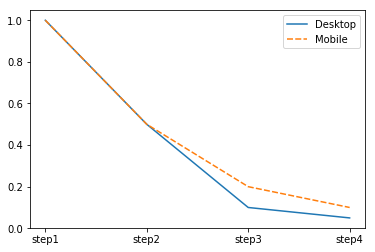

In [24]:
# Transpose the data to use in visualizations
transposed_calc = device_calculations.transpose()

sns.lineplot(data=transposed_calc)

In [25]:
# Create a table with the totals
device_totals = calculate_totals(device_group.copy()).iloc[:, 4:]

# Display the results
device_totals

,step1,step2,step3,step4
device,,,,
Desktop,1,0.5,0.05,0.002492
Mobile,1,0.5,0.10,0.010000


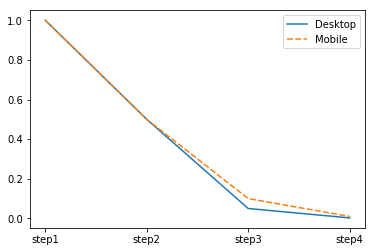

In [26]:
# Transpose the data to use in visualizations
transposed_total = device_totals.transpose()

sns.lineplot(data=transposed_total)

### First Look Summary:
- Mobile has a total conversion rate (from home -> payment confirmation) 4x greater than that of desktop. 
-  There is a huge dropoff difference from search -> payment, where 10% of users make it through on the desktop, but 20% make it through on the mobile..
- Similary, from the payment -> payment confirmation, 5% of desktop users make it through, whereass 10% make it through on the mobile.
- In terms of volume of lost users, the largest dropoff occurs at the home page to search page, where both the mobile and desktop lose approximately half of their users.

Let's take a closer look at these dropoffs by analyzing the dropoff relative to additional variables.

In [27]:
# Create a dataframe with graouped devices and sex
device_sex = create_df(merged_df, ['device', 'sex'])

# Display the results
device_sex

home_page  search_page  payment_page  \
device  sex                                            
Desktop Female      29997      15091.0        1530.0   
        Male        30203      15009.0        1480.0   
Mobile  Female      15078       7585.0        1570.0   
        Male        15122       7515.0        1450.0   

                payment_confirmation_page  
device  sex                                
Desktop Female                       74.0  
        Male                         76.0  
Mobile  Female                      167.0  
        Male                        135.0

In [28]:
# Create a table with the percentages lost
d_s_calc = calculate_steps(device_sex.copy()).iloc[:, 4:]

# Display the results
d_s_calc

step1     step2     step3     step4
device  sex                                        
Desktop Female      1  0.503084  0.101385  0.048366
        Male        1  0.496937  0.098608  0.051351
Mobile  Female      1  0.503051  0.206987  0.106369
        Male        1  0.496958  0.192947  0.093103

In [29]:
# Create a dataframe with graouped devices and sex
device_month = create_df(merged_df, ['device', 'month'])

# Display the results
device_month

home_page  search_page  payment_page  payment_confirmation_page
device  month                                                                 
Desktop 1          15050       7529.0        1221.0                       60.0
        2          15050       7632.0        1191.0                       54.0
        3          15050       7370.0         296.0                       14.0
        4          15050       7569.0         302.0                       22.0
Mobile  1           7550       6025.0        1169.0                      129.0
        2           7550       6055.0        1221.0                      119.0
        3           7550       1509.0         335.0                       30.0
        4           7550       1511.0         295.0                       24.0

In [30]:
# Create a table with the percentages lost
d_m_calc = calculate_steps(device_month.copy()).iloc[:, 4:]

# Display the results
d_m_calc

step1     step2     step3     step4
device  month                                     
Desktop 1          1  0.500266  0.162173  0.049140
        2          1  0.507110  0.156053  0.045340
        3          1  0.489701  0.040163  0.047297
        4          1  0.502924  0.039900  0.072848
Mobile  1          1  0.798013  0.194025  0.110351
        2          1  0.801987  0.201652  0.097461
        3          1  0.199868  0.222001  0.089552
        4          1  0.200132  0.195235  0.081356

In [31]:
# Create a dataframe with graouped devices and sex
device_week = create_df(merged_df, ['device', 'weekofyear'])

# Create a table with the percentages lost
d_w_calc = calculate_steps(device_week.copy()).iloc[:, 4:]

# Display the results
d_w_calc

step1     step2     step3     step4
device  weekofyear                                     
Desktop 1               1  0.504597  0.152834  0.039735
        2               1  0.498520  0.144893  0.057377
        3               1  0.506775  0.162805  0.040146
        4               1  0.489943  0.183578  0.060703
        5               1  0.508249  0.162301  0.038596
        6               1  0.503597  0.163776  0.056075
        7               1  0.507851  0.159382  0.030100
        8               1  0.506875  0.154787  0.051546
        9               1  0.503926  0.130575  0.045267
        10              1  0.481492  0.049200  0.075000
        11              1  0.492362  0.047136  0.012658
        12              1  0.499853  0.037647  0.046875
        13              1  0.489717  0.031041  0.058824
        14              1  0.478505  0.040517  0.072464
        15              1  0.495837  0.038796  0.119403
        16              1  0.518169  0.040309  0.027397
        17              1  0.510364  0.040066  0.109589
        18              1  0.505567  0.033033  0.000000
Mobile  1               1  0.805907  0.195026  0.127517
        2               1  0.782329  0.195961  0.125954
        3               1  0.796620  0.182151  0.096386
        4               1  0.794371  0.204628  0.106007
        5               1  0.816492  0.194168  0.106227
        6               1  0.808081  0.184868  0.099644
        7               1  0.789952  0.198241  0.102389
        8               1  0.800841  0.213911  0.085890
        9               1  0.730416  0.210059  0.095070
        10              1  0.201862  0.213256  0.108108
        11              1  0.208260  0.246459  0.103448
        12              1  0.198792  0.191489  0.095238
        13              1  0.189052  0.214925  0.069444
        14              1  0.205336  0.225989  0.125000
        15              1  0.216713  0.182519  0.084507
        16              1  0.183935  0.189873  0.050000
        17              1  0.191083  0.193939  0.062500
        18              1  0.205128  0.226852  0.061224

In [32]:
# Create the pre and post change week groupings
device_week.reset_index(inplace=True)

prechange_df = device_week[device_week['weekofyear'] <= 9].copy().groupby('device').sum()
postchange_df = device_week[device_week['weekofyear'] > 9].copy().groupby('device').sum()

# Apply the calculate_steps function
prechange_df = calculate_steps(prechange_df).iloc[:, 5:]
postchange_df = calculate_steps(postchange_df).iloc[:, 5:]

# Create a label column
prechange_df['group'] = '<wk10'
postchange_df['group'] = '>wk10'

# Concatenate the two dataframes
final_week_df = pd.concat([prechange_df, postchange_df])

# Set the index
final_week_df = final_week_df.reset_index().groupby(['device', 'group']).sum()

In [33]:
final_week_df

step1     step2     step3     step4
device  group                                     
Desktop <wk10      1  0.503368  0.157279  0.047088
        >wk10      1  0.496523  0.040049  0.061121
Mobile  <wk10      1  0.790705  0.197840  0.103333
        >wk10      1  0.199825  0.208825  0.087097

Note:
- There is a visible drop for desktop in conversion rate for search page to payment page from ~16 to ~4% after week 9.
    - An update that caused the search page to become faulty/less accessible or glitch with the payment page that prevents loading
- There is also a visible drop for mobile in conversion rate for home page to search page from ~79% to ~20% after week 9.
    - An update that caused an error with the home page or the loading of the searching page.
- Week 18 for Desktop has 0% conversion rate for payment page to payment confirmation page. 

In [34]:
# Create a dataframe with graouped devices and sex
device_day = create_df(merged_df, ['device', 'weekday'])

# Create a table with the percentages lost
d_d_calc = calculate_steps(device_day.copy()).iloc[:, 4:]

# Display the results
d_d_calc

step1     step2     step3     step4
device  weekday                                     
Desktop 0            1  0.501855  0.097736  0.052009
        1            1  0.500118  0.097087  0.065854
        2            1  0.499765  0.101432  0.034722
        3            1  0.496121  0.103887  0.055914
        4            1  0.495594  0.109768  0.036717
        5            1  0.502415  0.096154  0.063415
        6            1  0.504307  0.093952  0.041769
Mobile  0            1  0.497576  0.206961  0.123318
        1            1  0.477075  0.218334  0.094808
        2            1  0.481782  0.195568  0.096059
        3            1  0.506784  0.193664  0.092166
        4            1  0.516159  0.186472  0.090686
        5            1  0.528744  0.190706  0.101149
        6            1  0.491690  0.210329  0.100446

In [35]:
# Create a dataframe with graouped devices and sex
device_week_day = create_df(merged_df, ['device', 'weekofyear', 'weekday'])

# Create a table with the percentages lost
d_w_d_calc = calculate_steps(device_week_day.copy()).iloc[:, 4:]

In [36]:
d_w_d_calc[d_w_d_calc['step4']==0].reset_index()['weekday'].value_counts()

2    12
5    11
3    10
1    10
6     9
0     8
4     6
Name: weekday, dtype: int64

The occurrence of 0% conversion rate is 2x more prominent on Wednesday than on Friday.

## Conclusion:
1. Reduce losses (bring conversion rates back up) by fixing changes made after week 9.
    - Expect 3x increase in total conversion rates for desktop and 4x increase for mobile.
2. Address change made on week 18 to desktop interface for week 18.
3. Perform a comparative analysis of updates to bi-weekly performance metrics to understand how each update affected the conversion rates.

### Increase the variables:

1. If possible, I would collect ip address information in case the page's interface is being affected by the geographical location (if it's international?).
2. If there are any other forms of the website's interface, all that information should be collected.
3. To be safe, updates should be introduced subtly with A/B testing.